In [1]:
%load_ext watermark
%watermark

2020-09-11T08:10:12+08:00

CPython 3.7.4
IPython 7.4.0

compiler   : Clang 11.0.0 (clang-1100.0.33.8)
system     : Darwin
release    : 18.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt

In [3]:
X, y = make_moons(n_samples=100, shuffle=True, noise=0.1, random_state=42)
# X, y = make_circles(shuffle=True, factor=0.5)
y = np.array([1 if i == 1 else -1 for i in y])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, y_train.shape

((70, 2), (70,))

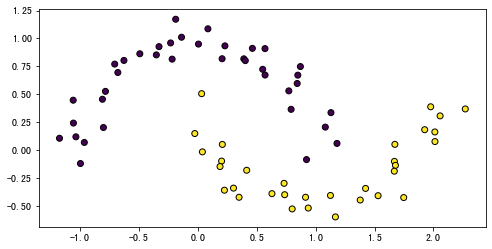

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,  edgecolors='k');

In [6]:
class SVM:
    
    def __init__(self, 
                 C: int = 1,
                 kernel: str = 'rbf', 
                 sigma: float = 0.1,
                 digree: int = 3,
                 epsion: float = 0.001,
                 max_iter: int = 100):
        self.C = C
        self.kernel = self.choose_kernel(kernel)
        self.sigma = sigma
        self.digree = digree
        self.epsion = epsion
        self.max_iter = max_iter
    
    def choose_kernel(self, kernel: str):
        if kernel == "linear":
            return self.linear_kernel
        elif kernel == "rbf":
            return self.rbf_kernel
        elif kernel == "poly":
            return self.poly_kernel
        else:
            raise NotImplemented
    
    def linear_kernel(self, xi: np.array, xj: np.array):
        return xi.dot(xj)
    
    def poly_kernel(self, xi: np.array, xj: np.array):
        return (xi.dot(xj) + 1) ** self.digree
    
    def rbf_kernel(self, xi: np.array, xj: np.array):
        return np.exp(-np.linalg.norm(xi - xj, ord=2)/(2 * self.sigma ** 2))
    
    def gx(self, i: int):
        return sum(
            [self.alpha[j] * self.y[j] * self.kernel(self.X[j], self.X[i]) for j in range(self.n)]
        ) + self.b
    
    def error(self, i: int):
        return self.gx(i) - self.y[i]
    
    def satisfy_kkt(self, i: int):
        alpha = self.alpha[i]
        ygx = self.y[i] * self.gx(i)
#         if np.abs(alpha - 0) < self.epsion:
        if alpha == 0:
            return ygx >= 1
#         elif np.abs(alpha - self.C) < self.epsion:
        elif alpha == self.C:
            return ygx <= 1
#         elif -self.epsion < alpha < self.C + self.epsion:
        elif 0 < alpha < self.C:
            return np.abs(ygx - 1) < self.epsion
        return False
    
    def init_args(self, features: np.array, labels: np.array):
        self.X = features
        self.y = labels
        self.n, self.dim = features.shape
        self.b = 0.0
        self.alpha = np.zeros(self.n)
        self.E = [self.error(i) for i in range(self.n)]
        self.svi = []
        self.cannot = []
    
    def init_alpha1(self):
        bound_points = [i for i in range(self.n) if 0 < self.alpha[i] < self.C]
        other_points = [i for i in range(self.n) if i not in bound_points]
        for i in bound_points + other_points:
            if i in self.svi:
                continue
            if i in self.cannot:
                continue
            if self.satisfy_kkt(i):
                continue
            return i
    
    def clip(self, alpha: float, low: float, high: float):
        if alpha < low:
            return low
        elif alpha > high:
            return high
        return alpha
    
    def fit(self, X, y):
        self.init_args(X, y)
        it = 0
        
        while it < self.max_iter:
            it += 1
            
            i1 = self.init_alpha1()
            if i1 == None:
                break
            E1 = self.error(i1)
            if E1 > 0:
                with_out_svi = min([e for i,e in enumerate(self.E) if i not in self.svi])
#                 with_out_svi = min(self.E)
            else:
                with_out_svi = max([e for i,e in enumerate(self.E) if i not in self.svi])
#                 with_out_svi = max(self.E)
            i2 = self.E.index(with_out_svi)
            
            chosen = [i1, i2]
            bound_points = [i for i in range(self.n) if 0 < self.alpha[i] < self.C and i not in chosen]
            bound_points = chosen + bound_points
            other_points = [i for i in range(self.n) if i not in bound_points]
            for i2 in bound_points + other_points:
                if i2 == i1:
                    continue
                if i2 in self.svi:
                    continue
            
                if self.y[i1] == self.y[i2]:
                    L = max(0, self.alpha[i1] + self.alpha[i2] - self.C)
                    H = min(self.C, self.alpha[i1] + self.alpha[i2])
                else:
                    L = max(0, self.alpha[i2] - self.alpha[i1])
                    H = min(self.C, self.C + self.alpha[i2] - self.alpha[i1])

                E1 = self.E[i1]
                E2 = self.E[i2]
                err = E1 - E2
                K11 = self.kernel(self.X[i1], self.X[i1])
                K22 = self.kernel(self.X[i2], self.X[i2])
                K12 = self.kernel(self.X[i1], self.X[i2])
                eta = K11 + K22 - 2*K12
                alpha2_new_unclipped = self.alpha[i2] + self.y[i2] * err / eta
                alpha2_new = self.clip(alpha2_new_unclipped, L, H)

                alpha1_new = self.alpha[i1] + self.y[i1] * self.y[i2] * (
                    self.alpha[i2] - alpha2_new)

                b1_new = (-E1 
                          - self.y[i1]*K11*(alpha1_new - self.alpha[i1])
                          - self.y[i2]*K12*(alpha2_new - self.alpha[i2])
                          + self.b)
                b2_new = (-E2 
                          - self.y[i1]*K12*(alpha1_new - self.alpha[i1])
                          - self.y[i2]*K22*(alpha2_new - self.alpha[i2])
                          + self.b)

                if 0 < alpha1_new < self.C and 0 < alpha2_new < self.C:
                    b_new = b1_new
                else:
                    b_new = (b1_new + b2_new) / 2

                if np.abs(alpha2_new - self.alpha[i2]) > self.epsion:
                    self.svi.append(i1)
                    self.svi.append(i2)
                    self.b = b_new
                    self.alpha[i1] = alpha1_new
                    self.alpha[i2] = alpha2_new
                    self.E[i1] = self.error(i1)
                    self.E[i2] = self.error(i2)
                    break
            if i1 not in self.svi:
                self.cannot.append(i1)
        
        print(self.alpha)
        print(self.svi)
        print(self.cannot)
#         for i in range(self.n):
#             satis = self.satisfy_kkt(i)
#             print(i, satis)
        

    def predict_single(self, x):
        res = sum(
            [self.alpha[j] * self.y[j] * self.kernel(self.X[j], x) for j in self.svi]
        ) + self.b
        return np.sign(res)
    
    def predict(self, X):
        res = []
        for i in range(len(X)):
            pred = self.predict_single(X[i])
            res.append(pred)
        return np.array(res)
    
    def score(self, X, y):
        preds = self.predict(X)
        return sum(preds == y) / len(y)

In [7]:
svm = SVM()

In [8]:
svm.fit(X_train, y_train)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
[0, 2, 1, 3, 4, 5, 6, 10, 7, 11, 8, 12, 9, 15, 13, 17, 14, 20, 16, 21, 18, 22, 19, 23, 24, 25, 26, 27, 28, 30, 29, 33, 31, 34, 32, 35, 36, 37, 38, 39, 40, 41, 42, 44, 43, 46, 45, 47, 48, 50, 49, 52, 51, 56, 53, 58, 54, 60, 55, 64, 57, 65, 59, 69]
[61, 62, 63, 66, 67, 68]


In [9]:
svm.score(X_test, y_test)

1.0